In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats as st
from scipy.stats import linregress
import math

# import ArcGIS modules from ESRI (requires license)

import arcgis
from arcgis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor

## Get Atlanta Neighborhood Planning Unit (NPU) GIS Layer

In [2]:
# get the NPU data from the Atlanta arcgis web service using the GIS object 'get' function
# As opposed to a an api get request, this retreives the data as the data type(feature layer) needed as input for later spatial functions

item = GIS().content.get('8979666ab4064d62867204282111151d')
flayer = item.layers[0]
item

<Item title:"Official NPU" type:Feature Layer Collection owner:pthomas7285>

In [3]:
# create a Spatially Enabled DataFrame object

npu = pd.DataFrame.spatial.from_layer(flayer)
npu.head()

#note the added 'SHAPE' column

,OBJECTID,NAME,GEOTYPE,FULLFIPS,ACRES,SQMILES,OLDNAME,NPU,CREATED_USER,CREATED_DATE,LAST_EDITED_USER,LAST_EDITED_DATE,GLOBALID,Shape__Area,Shape__Length,SHAPE
0,251,M,NPU,None,2421.90,3.78,None,None,pthomas7285,2021-10-15 20:41:49.766000032,pthomas7285,2021-10-15 20:41:49.766000032,74f21c58-742f-4e79-99e0-2f2749579eeb,1.421945e+07,16218.047071,"{""rings"": [[[-9392012.5074186, 3998477.0773647..."
1,252,Y,NPU,None,2106.63,3.29,None,None,pthomas7285,2021-10-15 20:41:49.766000032,pthomas7285,2021-10-15 20:41:49.766000032,64802558-2dc7-4efd-a0b9-66d50b73c8b1,1.235426e+07,16010.793448,"{""rings"": [[[-9391854.62362555, 3991892.286540..."
2,253,L,NPU,None,846.17,1.32,None,None,pthomas7285,2021-10-15 20:41:49.766000032,pthomas7285,2021-10-15 20:41:49.766000032,7cb60e1b-fa45-4035-b45b-f693e7526874,4.968765e+06,10790.907463,"{""rings"": [[[-9397131.68607033, 3999644.049650..."
3,254,V,NPU,None,2027.09,3.17,None,None,pthomas7285,2021-10-15 20:41:49.766000032,pthomas7285,2021-10-15 20:41:49.766000032,c9e52550-fa86-4f1e-b34b-dac5f795be30,1.189405e+07,14447.131749,"{""rings"": [[[-9393191.78650693, 3994697.156670..."
4,255,B,NPU,None,6516.11,10.18,None,None,pthomas7285,2021-10-15 20:41:49.766000032,pthomas7285,2021-10-15 20:41:49.766000032,1487f50c-e325-47f2-9a1e-a9f0e313bc1d,3.833490e+07,29059.929715,"{""rings"": [[[-9389586.03159145, 4012972.102098..."


## Get Grocery Store Data from Yelp API

In [4]:
# Setup the url for the API call, and include key from config file

url = "https://api.yelp.com/v3/businesses/search?&location=Atlanta,GA&categories="
api_key = yelp_api_key
headers = {"Authorization": "Bearer " + api_key}

In [5]:
# Make call and include limit and offsets

atlantagroceries_raw = []
offset = [0,51,101,151,201,251,301,351,401,451,501]
for offsetting in offset:
    params = {
            'limit': 50,
            'offset': offsetting
        }
    responses = requests.get(url+ "grocery",headers=headers,params=params).json()
    atlantagroceries_raw.append(responses)
print(atlantagroceries_raw)

[{'businesses': [{'id': 'KbyrRWuEeK6uEbtpAUgIdg', 'alias': 'littles-food-store-and-grill-atlanta', 'name': "Little's Food Store and Grill", 'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/WLyI4YgVz1nc1xOnr-yIbA/o.jpg', 'is_closed': False, 'url': 'https://www.yelp.com/biz/littles-food-store-and-grill-atlanta?adjust_creative=snrJLEHqJkQMzzV_Rc2HBw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=snrJLEHqJkQMzzV_Rc2HBw', 'review_count': 189, 'categories': [{'alias': 'grocery', 'title': 'Grocery'}, {'alias': 'beer_and_wine', 'title': 'Beer, Wine & Spirits'}, {'alias': 'burgers', 'title': 'Burgers'}], 'rating': 4.5, 'coordinates': {'latitude': 33.74923, 'longitude': -84.36784}, 'transactions': ['delivery'], 'price': '$', 'location': {'address1': '198 Carroll St', 'address2': '', 'address3': '', 'city': 'Atlanta', 'zip_code': '30312', 'country': 'US', 'state': 'GA', 'display_address': ['198 Carroll St', 'Atlanta, GA 30312']}, 'phone': '+14049637012', 'display_phone

In [6]:
# Set up lists that will be used to create the data frame

name = []
lat = []
long = []
for range in range(11):
    groceries = atlantagroceries_raw[(int(range))]['businesses']
    for atlantagrocery in groceries:
        name.append(atlantagrocery['name'])
        lat.append(atlantagrocery['coordinates']['latitude'])
        long.append(atlantagrocery['coordinates']['longitude'])
print(f"The name information received is: {name}")
print(f"The latitude information received is: {lat}")
print(f"The longitude information received is: {long}")

The name information received is: ["Little's Food Store and Grill", "Trader Joe's", "Trader Joe's", 'Sevananda Natural Foods Market', 'Candler Park Market', 'Whole Foods Market', 'Whole Foods Market - Atlanta', 'Whole Foods Market', "Bennett's Market & Deli", 'Grant Park Market', 'Publix', 'Savi Provisions: Inman Park', 'The Fresh Market', 'Savi Provisions: Roswell Road', 'Publix', 'Kroger', 'Al-Amin Restaurant', 'Brito Supermarket', 'Publix', 'Sprouts Farmers Market', 'Whole Foods Market - Atlanta', 'Kroger', 'Publix', 'Savi Provisions: Brookhaven', 'Publix', 'Publix', 'Publix', 'Carniceria Ramirez', 'Oak Grove Market', 'Kroger', 'Savi Provisions: Midtown', 'Kroger', 'L & M Service Market', 'Whole Foods Market', 'Kroger', 'Publix', 'Lidl', 'Publix', 'The Fresh Market', 'Kelly’s Market', 'The Kroger Company', 'the spicy peach', 'Publix', 'Kroger', 'ALDI', 'Publix', 'Publix', 'Publix', 'Publix', 'Publix', 'Publix', 'Publix', 'Publix', 'Publix', 'Publix', 'ALDI', 'Big Bear Foods', 'Goodn

In [7]:
# Create the data frame

Grocery_df = {
    "Name": name,
    "Latitude": lat,
    "Longitude": long
}
grocery_data = pd.DataFrame(Grocery_df)
grocery_data.head(200)

,Name,Latitude,Longitude
0,Little's Food Store and Grill,33.749230,-84.367840
1,Trader Joe's,33.778754,-84.367020
2,Trader Joe's,33.840953,-84.374985
3,Sevananda Natural Foods Market,33.767123,-84.348642
4,Candler Park Market,33.765110,-84.333490
...,...,...,...
141,"Wayfield Foods, Inc.",33.739700,-84.253708
142,Savi Provisions,33.775373,-84.298494
143,Super Giant Foods,33.792145,-84.286277
144,Texaco Food Mart,33.838116,-84.480225


In [8]:
# Use ArcGIS module to convert the pandas dataframe to an ArcGIS spatially enabled dataframe

grocery_sedf = pd.DataFrame.spatial.from_xy(df=grocery_data, x_column='Longitude', y_column='Latitude')
grocery_sedf.head()

,Name,Latitude,Longitude,SHAPE
0,Little's Food Store and Grill,33.749230,-84.367840,"{""spatialReference"": {""wkid"": 4326}, ""x"": -84...."
1,Trader Joe's,33.778754,-84.367020,"{""spatialReference"": {""wkid"": 4326}, ""x"": -84...."
2,Trader Joe's,33.840953,-84.374985,"{""spatialReference"": {""wkid"": 4326}, ""x"": -84...."
3,Sevananda Natural Foods Market,33.767123,-84.348642,"{""spatialReference"": {""wkid"": 4326}, ""x"": -84...."
4,Candler Park Market,33.765110,-84.333490,"{""spatialReference"": {""wkid"": 4326}, ""x"": -84...."


In [9]:
# run a function that validates if the object is indeed a spatially enabled data frame (bool)

grocery_sedf.spatial.validate()

True

In [10]:
grocery_sedf.spatial.to_featureclass(location=r"C:\Users\hhhbh\Documents\ArcGIS\Projects\BCproject_1\BCproject_1.gdb\grocery")


'C:\\Users\\hhhbh\\Documents\\ArcGIS\\Projects\\BCproject_1\\BCproject_1.gdb\\grocery'

## Spatial Join the Neighborhood to the grocery stores

In [11]:
# The spatial join function requires that the two dataframes be in the same coordinate system (spatial reference).
# The spatial reference of each dataframe can be seen in the SHAPE column. 
# To make them the same, convert the grocery dataframe spatial reference to the same as the NPU dataframe

grocery_sedf.spatial.project(3857)

True

In [12]:
# Use the spatial join function to create a new dataframe that has NPU joined to the grocery stores
# this function joines the records based on thier spatial intersection
# (i.e. joins NPU record to grocery record if the grocery's XY is within the NPUs area)

grocery_join = pd.DataFrame(grocery_sedf.spatial.join(npu,how='right'))[['Name','NAME']]
grocery_join

,Name,NAME
0,Publix,M
1,Southern Food Store,M
2,Carver Neighborhood Market,Y
3,Walmart,L
4,Sam & Son Grocery Wholesale,V
...,...,...
67,Kroger,W
68,ALDI,W
69,Dollar General,W
70,Piggly Wiggly,W


## Get Crime Data

In [13]:
#Access the Crime csv file

crime_path = r"C:\Users\hhhbh\Documents\DataBootcamp\Projects\Project1\Project-1\Resources\COBRA_final_2021.csv"
crime = pd.read_csv(crime_path)
crime.head()

,offense_id,rpt_date,occur_date,occur_day,occur_day_num,occur_time,poss_date,poss_time,beat,zone,location,neighborhood,ibr_code,UC2_Literal,npu,lat,long,Unnamed: 17,Crime Sheet removals
0,21140096.0,5/20/2021,5/19/2021,Wednesday,4.0,15:20,5/19/2021,15:25,103.0,1.0,"1720 MARIETTA BLVD NW\nATLANTA, GA 30318\nUNIT...",Hills Park,23F,LARCENY-FROM VEHICLE,D,33.801693,-84.436453,NaN,NaN
1,21791668.0,6/28/2021,6/27/2021,Sunday,1.0,21:17,6/28/2021,20:00,102.0,1.0,"870 MAYSON TURNER RD NW\nATLANTA, GA 30314\nUN...",Vine City,23H,LARCENY-NON VEHICLE,L,33.755768,-84.416631,NaN,NaN
2,200041082.0,1/5/2021,1/4/2021,Monday,2.0,16:00,1/4/2021,17:00,605.0,6.0,"275 MEMORIAL DR SE\nATLANTA, GEORGIA 30312\nUN...",Grant Park,23C,LARCENY-NON VEHICLE,W,33.746503,-84.378535,NaN,NaN
3,202611428.0,9/18/2021,9/18/2021,Saturday,7.0,18:04,9/18/2021,18:15,112.0,1.0,"2750 DONALD LEE HOLLOWELL PKWY NW\nATLANTA, GA...",Collier Heights,23C,LARCENY-NON VEHICLE,I,33.777383,-84.477433,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot Crime Data by Neighborhood

In [14]:
#Group the crime data by NPU

crime_npu = crime[['offense_id','npu']].groupby('npu').nunique()
crime_npu = crime_npu.rename(columns={'offense_id': 'Incident Count'})
crime_npu.head()

,Incident Count
npu,
A,136
B,2175
C,434
D,897
E,2747


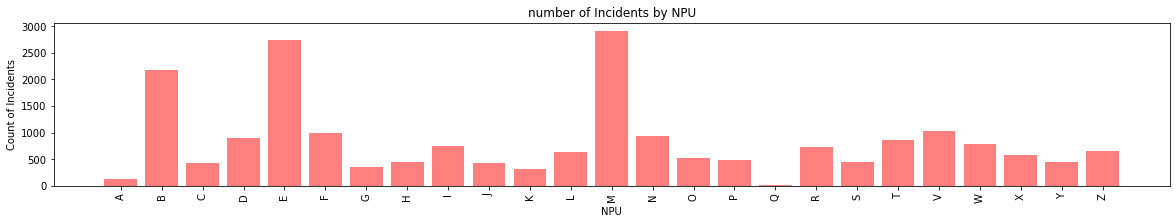

In [15]:
 # Set x axis and tick locations   
x_axis = np.arange(len(crime_npu))
tick_locations = [value+0.4 for value in x_axis]

# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,3))
plt.bar(x_axis, crime_npu["Incident Count"], color='r', alpha=0.5, align="edge")
plt.xticks(tick_locations, crime_npu.index, rotation="vertical")

 # Set a Title and labels
plt.title("number of Incidents by NPU")
plt.xlabel("NPU")
plt.ylabel("Count of Incidents")
plt.show()


In [16]:
 # Save our graph and show the grap
plt.tight_layout()
plt.savefig(r"C:\Users\hhhbh\Documents\DataBootcamp\Projects\Project1\Project-1\Resources\Images\Crime_per_NPU.png")
plt.show()

<Figure size 432x288 with 0 Axes>

## Plot Grocery Data by Neighborhood

In [17]:
grocery_npu = grocery_join.groupby('NAME').count()
grocery_npu = pd.DataFrame(grocery_npu)
grocery_npu = grocery_npu.rename(columns={'Name':'Grocery Store Count'})

In [18]:
 # Set x axis and tick locations
x_axis = np.arange(len(grocery_npu))
tick_locations = [value+0.4 for value in x_axis]

# Create a list indicating where to write x labels and set figure size to adjust for space
plt.figure(figsize=(20,3))
plt.bar(x_axis, grocery_npu["Grocery Store Count"], color='r', alpha=0.5, align="edge")
plt.xticks(tick_locations, grocery_npu.index, rotation="vertical")

 # Set a Title and labels
plt.title("number of Grocery Stores by NPU")
plt.xlabel("NPU")
plt.ylabel("Count of Grocery Stores")

Text(0, 0.5, 'Count of Grocery Stores')

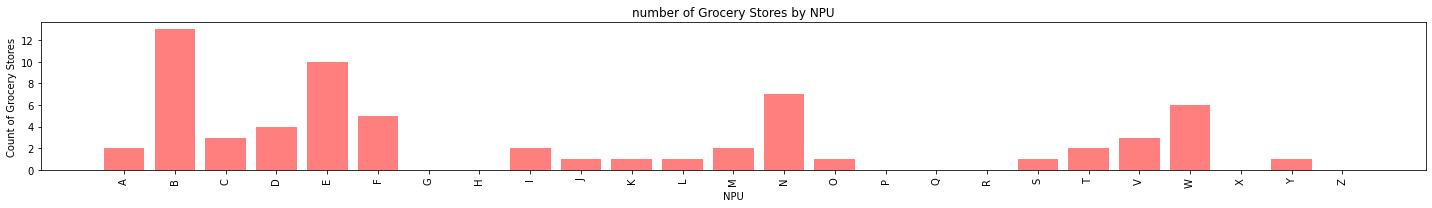

In [19]:
 # Save our graph and show the graph
plt.tight_layout()
plt.savefig(r"C:\Users\hhhbh\Documents\DataBootcamp\Projects\Project1\Project-1\Resources\Images\Grocery_per_NPU.png")
plt.show()

## Scatter plotting

In [20]:
merged_npu = grocery_npu.merge(crime_npu, how='right',left_index=True,right_index=True)
merged_npu = pd.DataFrame(merged_npu)
merged_npu

,Grocery Store Count,Incident Count
npu,,
A,2,136
B,13,2175
C,3,434
D,4,897
E,10,2747
F,5,992
G,0,356
H,0,451
I,2,752


In [21]:
# Removed bad data NPUs (did not get grocery data for these based on the radius of the Yelp search for "Atlanta")
merged_npu.drop(['Z','S','X','Y','R','P','Q','H'])

,Grocery Store Count,Incident Count
npu,,
A,2,136
B,13,2175
C,3,434
D,4,897
E,10,2747
F,5,992
G,0,356
I,2,752
J,1,423


In [22]:
#create scatter plot
x = 'Incident Count'
y = 'Grocery Store Count'

plt.scatter(merged_npu[x], merged_npu[y])

# format labels
plt.title(f"NPU {x} vs. {y}")

plt.xlabel(x)

plt.ylabel(y)

Text(0, 0.5, 'Grocery Store Count')

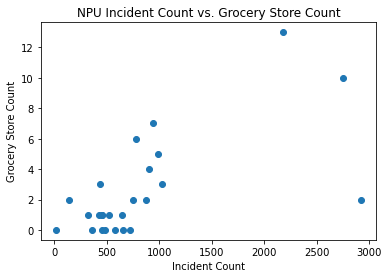

In [23]:
 # Save our graph and show the graph
#plt.tight_layout()
plt.savefig(r"C:\Users\hhhbh\Documents\DataBootcamp\Projects\Project1\Project-1\Resources\Images\NPU_Grocery_vs_Incident.png")
plt.show()

In [24]:
df = merged_npu
x = 'Incident Count'
y = 'Grocery Store Count'

df_x = df[x]
df_y = df[y]

# get r-squared value and print it
print(f"r-squared: {round(st.pearsonr(df[x], df[y])[0],2)}")

# calculate function for line and plot
(slope, intercept, rvalue, pvalue, stderr) = linregress(df[x], df[y])
regress_values = df[x] * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(df[x],regress_values,"r-")

# add scatter plot
plt.scatter(df[x], df[y])

# format labels
plt.title(f'NPU {x} vs. {y} Linear Regression')

plt.xlabel(x)

plt.ylabel(y)

r-squared: 0.66


Text(0, 0.5, 'Grocery Store Count')

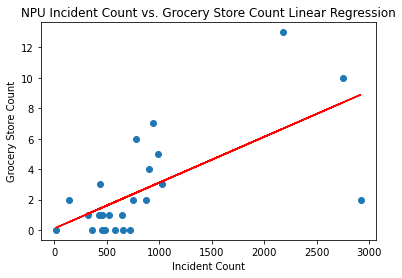

In [25]:
 # Save our graph and show the graph
plt.savefig(r"C:\Users\hhhbh\Documents\DataBootcamp\Projects\Project1\Project-1\Resources\Images\NPU_Grocery_vs_Incident_R.png")
plt.show()